# Tutorial 1 - Decision Tree - Regression

We will predict the price (`price` column) of an AirBNB listing in Boston given a number of features about the listing.

**Therefore, our unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_75-150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                       0
host_identity_verified                  0
neighbourhood_cleansed                  0
latitude                                0
longitude                               0
property_type                           8
room_type                               0
accommodates                            0
bathrooms                              19
bedrooms                               19
beds                                   16
bed_type                                0
Number of amenities                     0
guests_included                         0
price_per_extra_person                  0
minimum_nights                          0
number_of_reviews                       0
number_days_btw_first_last_review       0
review_scores_rating                 1609
cancellation_policy                     0
price                                   0
price_gte_150                           0
price_category                          0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                             17
bedrooms                              11
beds                                   8
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 674
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are for classification tasks

train = train_set.drop(['price_gte_150', 'price_category'], axis=1)
test = test_set.drop(['price_gte_150', 'price_category'], axis=1)

## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train[['price']]
test_y = test[['price']]

train_inputs = train.drop(['price'], axis=1)
test_inputs = test.drop(['price'], axis=1)

## Feature Engineering: Let's derive a new column

#### Formula: `reviews per day` = `number of reviews` / `number_days_btw_first_last_review`

In [9]:
def new_col(df):
    
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()

    # Use the formula, though fill in 0s when the value is 0/0 (because 0/0 generates "nan" values)
    df1['reviews_per_day'] = (df1['number_of_reviews']/df1['number_days_btw_first_last_review']).fillna(0)

    # Replace the infinity values with 1 (because a value divided by 0 generates infinity)
    df1['reviews_per_day'].replace(np.inf, 1, inplace=True)

    return df1[['reviews_per_day']]
    # You can use this to check whether the calculation is made correctly:
    #return df1
    

In [10]:
#Let's test the new function:

# Send the train set to the function we created
new_col(train_set)

,reviews_per_day
3437,0.176471
6622,1.000000
2262,0.016129
2246,0.067511
835,0.136364
...,...
5734,0.017391
5191,0.056159
5390,0.016807
860,0.088235


##  Identify the numerical and categorical columns

In [11]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [12]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [13]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [14]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [15]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [16]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [17]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [18]:
feat_eng_columns = ['number_of_reviews', 'number_days_btw_first_last_review']

# Pipeline

In [19]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [20]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [21]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [22]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [23]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [24]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-2.10940159, -1.39824237,  1.20477863, ...,  0.        ,
         1.        , -0.03352521],
       [ 0.61906783, -1.38593382, -1.16133947, ...,  0.        ,
         0.        ,  2.59474554],
       [ 0.14448465, -0.16705969, -1.16133947, ...,  0.        ,
         1.        , -0.54525073],
       ...,
       [ 0.82039585,  0.74441303, -0.56980994, ...,  0.        ,
         0.        , -0.5430879 ],
       [-0.92762441,  0.3821493 , -0.56980994, ...,  0.        ,
         1.        , -0.31512564],
       [-0.34071414, -0.53929512, -1.16133947, ...,  0.        ,
         0.        , -0.59672608]])

In [25]:
train_x.shape

(7190, 62)

# Tranform: transform() for TEST

In [26]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[ 0.63069768,  0.40533687,  1.79630816, ...,  0.        ,
         1.        , -0.52500762],
       [ 0.15153485,  0.27611111, -0.56980994, ...,  0.        ,
         1.        , -0.55666577],
       [-2.02789334, -0.91924215,  0.02171958, ...,  0.        ,
         1.        , -0.31472523],
       ...,
       [ 0.15906806, -0.38872897,  1.20477863, ...,  0.        ,
         1.        , -0.53622425],
       [ 0.11838687, -0.56878308, -0.56980994, ...,  0.        ,
         0.        , -0.59672608],
       [-0.94171792,  0.19283558, -1.16133947, ...,  0.        ,
         1.        , -0.53947995]])

In [27]:
test_x.shape

(3082, 62)

# Calculate the baseline

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
#First find the average value of the target

mean_value = np.mean(train_y['price'])

mean_value

158.68289290681503

In [30]:
# Predict all values as the mean

baseline_pred = np.repeat(mean_value, len(test_y))

baseline_pred

array([158.68289291, 158.68289291, 158.68289291, ..., 158.68289291,
       158.68289291, 158.68289291])

In [31]:
baseline_mse = mean_squared_error(test_y, baseline_pred)

baseline_rmse = np.sqrt(baseline_mse)

print('Baseline RMSE: {}' .format(baseline_rmse))

Baseline RMSE: 91.62041893023937


In [32]:
train_y['price']

3437    150
6622     45
2262    100
2246    142
835     229
       ... 
5734    249
5191    100
5390    275
860     100
7270     59
Name: price, Length: 7190, dtype: int64

# Train the model

Do NOT train a DecisionTreeRegressor() without any parameters. It OVERFITS. 

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf = 10) # remove parameter to have un-restricted learning

tree_reg.fit(train_x, train_y)

DecisionTreeRegressor(min_samples_leaf=10)

In [45]:
#Train RMSE
train_pred = tree_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 32.210071836739075


In [46]:
#Test RMSE
test_pred = tree_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 42.13534157864597


## More regularization

In [77]:
#Let's restrict the depth as well

tree_reg2 = DecisionTreeRegressor(min_samples_leaf = 10, max_depth=5) # additional restriction on learning parameters

tree_reg2.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

In [78]:
#Train RMSE
train_pred = tree_reg2.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 54.64455131648256


In [79]:
#Test RMSE
test_pred = tree_reg2.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 56.36946611643262


In [85]:
np.round(tree_reg2.feature_importances_,2) # what columns are important? only a few...

array([0.06, 0.06, 0.02, 0.03, 0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.66, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01])

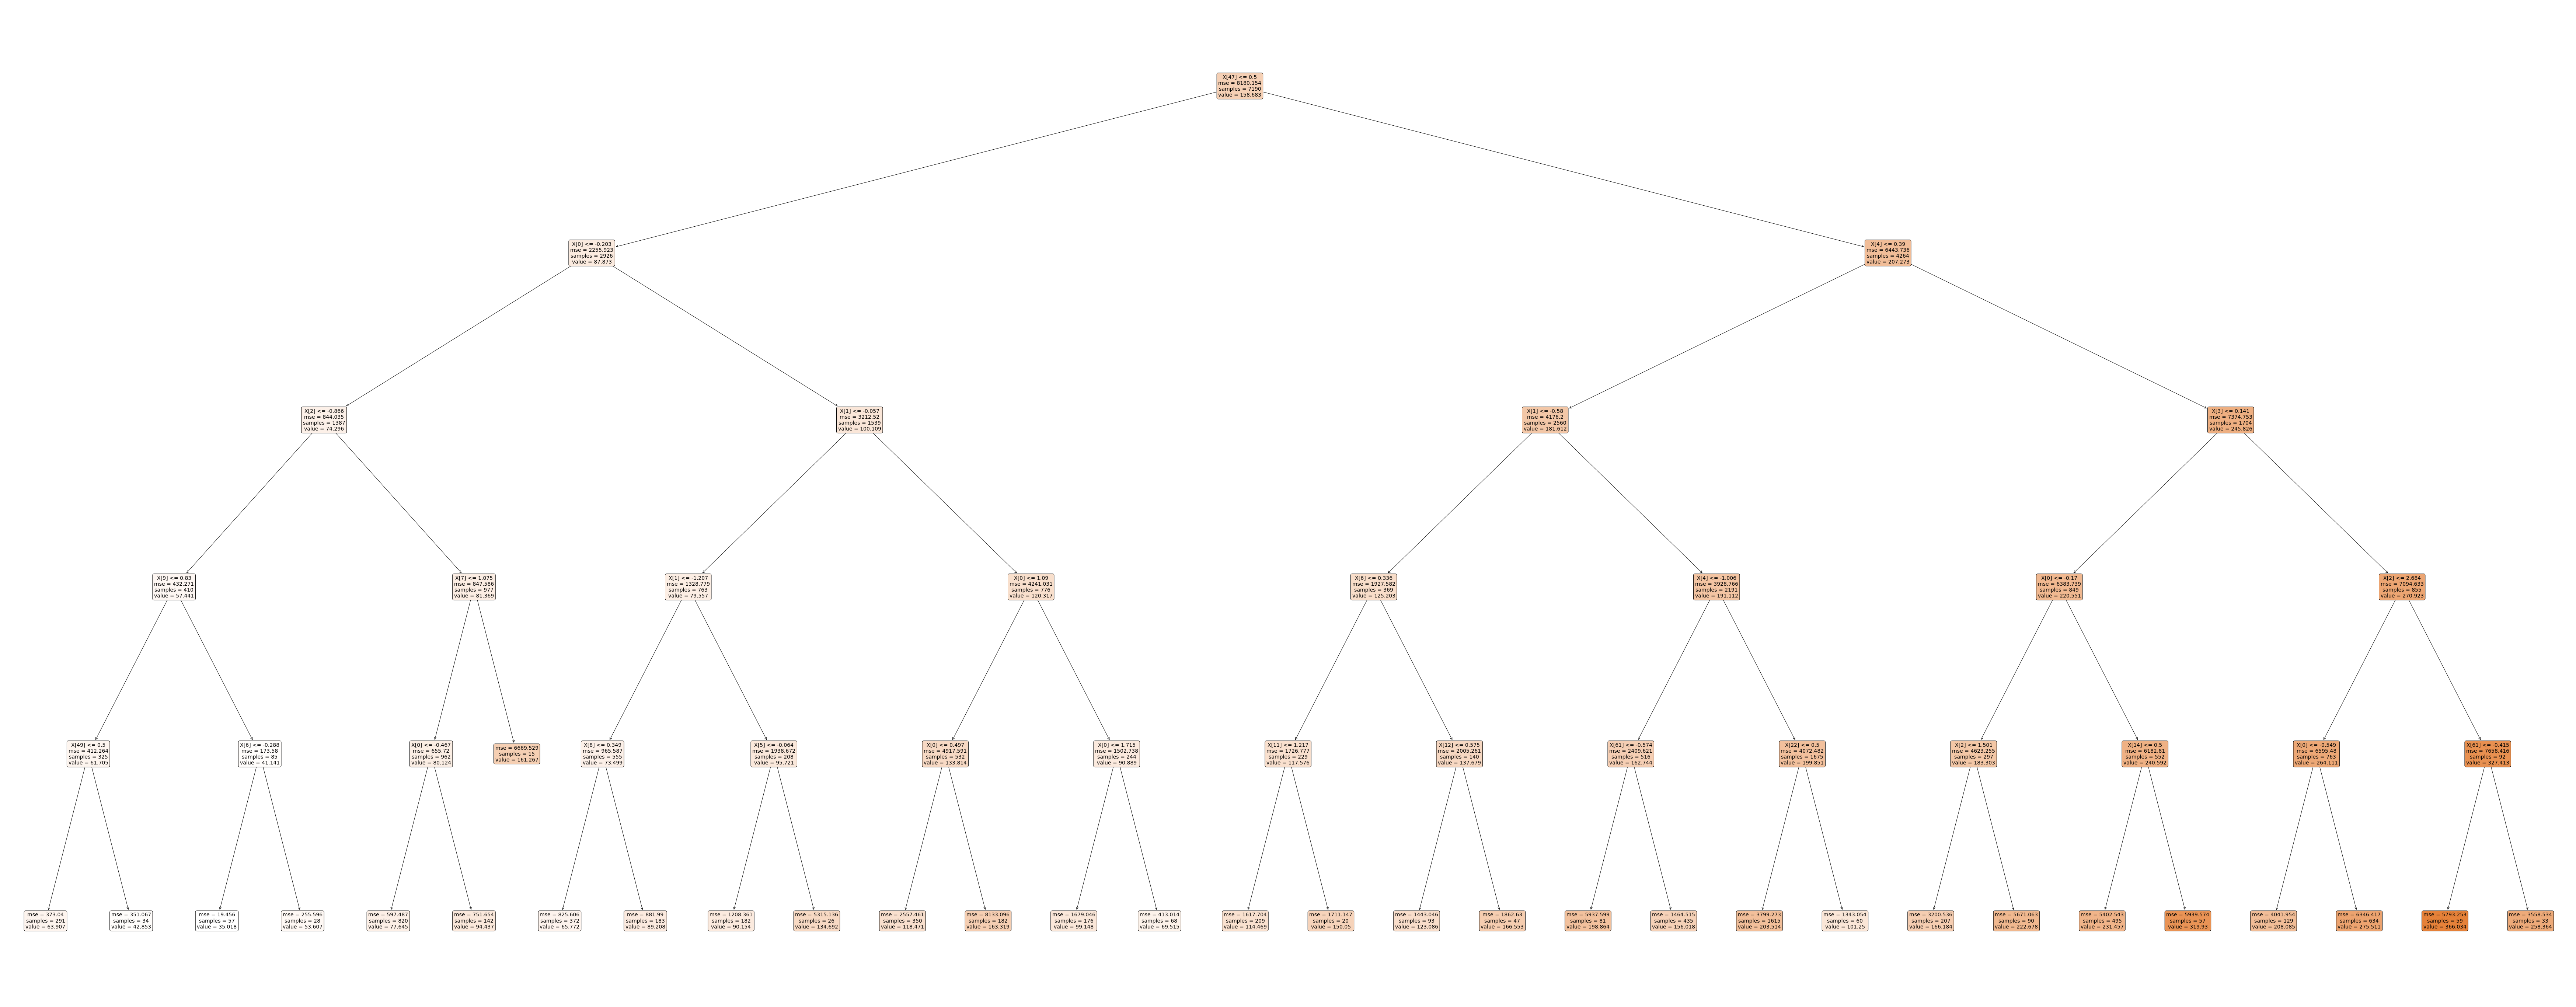

In [81]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))

tree = plot_tree(tree_reg2,
                 #feature_names=train_inputs.columns.value, # our feature names are stripped form the data set
                 #class_names=np.unique(train_y),
                 filled=True,
                 rounded=True,
                 fontsize=14)

## Avoid Overfitting

In [50]:
train_error = []
test_error = []

for x in range(1,31):
    tree_reg3 = DecisionTreeRegressor(max_depth=x)
    tree_reg3.fit(train_x, train_y)
    reg_train_predictions = tree_reg3.predict(train_x)
    reg_test_predictions = tree_reg3.predict(test_x)
    train_rmse = round(np.sqrt(mean_squared_error (train_y, reg_train_predictions)),4)
    test_rmse = round(np.sqrt(mean_squared_error (test_y, reg_test_predictions)),4)
    print('# Max depth = {}'.format(x) + "     " +'Train RMSE = {}'.format(train_rmse) + "   "
         'Test RMSE = {}'.format(test_rmse))
    
    train_error.append(train_rmse)
    test_error.append(test_rmse)


# Max depth = 1     Train RMSE = 68.8439   Test RMSE = 70.7368
# Max depth = 2     Train RMSE = 63.9154   Test RMSE = 65.3619
# Max depth = 3     Train RMSE = 60.2673   Test RMSE = 61.4147
# Max depth = 4     Train RMSE = 57.7447   Test RMSE = 58.6484
# Max depth = 5     Train RMSE = 54.4249   Test RMSE = 56.5256
# Max depth = 6     Train RMSE = 51.1229   Test RMSE = 53.9627
# Max depth = 7     Train RMSE = 47.8803   Test RMSE = 51.5204
# Max depth = 8     Train RMSE = 44.6398   Test RMSE = 48.587
# Max depth = 9     Train RMSE = 40.9472   Test RMSE = 44.8885
# Max depth = 10     Train RMSE = 37.0888   Test RMSE = 42.1419
# Max depth = 11     Train RMSE = 33.5333   Test RMSE = 39.4666
# Max depth = 12     Train RMSE = 30.1843   Test RMSE = 36.9042
# Max depth = 13     Train RMSE = 26.9904   Test RMSE = 34.6142
# Max depth = 14     Train RMSE = 23.8282   Test RMSE = 32.8863
# Max depth = 15     Train RMSE = 20.7797   Test RMSE = 30.3762
# Max depth = 16     Train RMSE = 17.736   Test RM

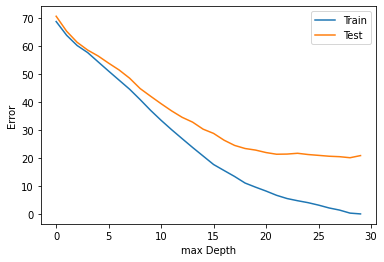

In [53]:
plt.plot(train_error, label='Train')
plt.plot(test_error, label='Test')
plt.xlabel("max Depth")
plt.ylabel("Error")
plt.legend()

# Randomized Grid Search

In [60]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'min_samples_leaf': np.arange(10, 30), 
     'max_depth': np.arange(10,30)}
  ]

tree_reg = DecisionTreeRegressor()

grid_search = RandomizedSearchCV(tree_reg, param_grid, cv=5, n_iter=10,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions=[{'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]),
                                         'min_samples_leaf': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [61]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

47.20799878499441 {'min_samples_leaf': 11, 'max_depth': 12}
50.40117698454035 {'min_samples_leaf': 28, 'max_depth': 11}
47.208850321700645 {'min_samples_leaf': 15, 'max_depth': 19}
50.369486611738616 {'min_samples_leaf': 23, 'max_depth': 10}
47.767465155828546 {'min_samples_leaf': 16, 'max_depth': 29}
49.77578415531906 {'min_samples_leaf': 27, 'max_depth': 19}
47.81464115402334 {'min_samples_leaf': 17, 'max_depth': 26}
47.22025540648551 {'min_samples_leaf': 15, 'max_depth': 27}
49.658025000204 {'min_samples_leaf': 26, 'max_depth': 12}
44.87309397473957 {'min_samples_leaf': 10, 'max_depth': 19}


In [62]:
grid_search.best_params_

{'min_samples_leaf': 10, 'max_depth': 19}

In [63]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=19, min_samples_leaf=10)

In [64]:
#Train RMSE
train_pred = grid_search.best_estimator_.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 32.60401189508503


In [65]:
#Test RMSE
test_pred = grid_search.best_estimator_.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 42.2587885098792
